In [1]:
# Pydata stack
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Custom module for cubic splines
from cubspl import gen_nat_cubic_spl_basis_fun

# QDA model
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

# Metrics
from sklearn.metrics import accuracy_score

# To apply data filter
from sklearn.preprocessing import FunctionTransformer

# Pipelines
from sklearn.pipeline import Pipeline

# For cross-validation
from sklearn.model_selection import GridSearchCV

In [2]:
# Import data
df = pd.read_csv('phoneme-data.csv', skipinitialspace=True, header=0, index_col=0)

# Look at data
df.head()

,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10,x.11,x.12,x.13,x.14,x.15,x.16,x.17,x.18,x.19,x.20,x.21,x.22,x.23,x.24,x.25,x.26,x.27,x.28,x.29,x.30,x.31,x.32,x.33,x.34,x.35,x.36,x.37,x.38,x.39,x.40,...,x.219,x.220,x.221,x.222,x.223,x.224,x.225,x.226,x.227,x.228,x.229,x.230,x.231,x.232,x.233,x.234,x.235,x.236,x.237,x.238,x.239,x.240,x.241,x.242,x.243,x.244,x.245,x.246,x.247,x.248,x.249,x.250,x.251,x.252,x.253,x.254,x.255,x.256,g,speaker
row.names,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,9.85770,9.20711,9.81689,9.01692,9.05675,8.92518,11.28308,11.52980,10.79713,9.04747,11.38065,11.61545,10.31166,12.14300,10.65254,11.19395,11.27878,11.13465,11.82706,12.81048,12.32239,10.27542,9.57760,10.62308,11.34983,11.58342,12.19465,10.67933,9.95300,11.47047,11.74805,11.28167,11.51648,12.50765,12.10918,11.97849,10.80743,9.65682,10.71985,9.50841,...,12.57110,10.00457,12.09898,14.08718,13.97254,11.74888,13.23555,13.76750,13.53994,12.28767,13.48164,13.43467,11.43232,11.01716,13.02529,13.37422,7.72797,12.32757,13.37041,12.68903,13.41566,13.16755,13.62844,13.32554,12.46720,13.84955,10.83688,11.23451,13.19359,12.94519,12.68076,11.20767,13.69394,13.72055,12.16628,12.92489,12.51195,9.75527,sh,train.dr1.mcpm0.sa1
2,13.23079,14.19189,15.34428,18.11737,19.53875,18.32726,17.34169,17.16861,19.63557,20.15212,18.84739,19.35436,19.61419,20.32628,21.41752,20.14227,17.97866,16.32943,17.63076,16.51955,15.95348,16.77282,16.98819,18.32396,17.59234,15.94519,13.31152,15.36856,16.10275,14.76571,14.85925,11.89751,14.90796,15.49864,15.13160,14.41750,11.42785,14.15725,13.80756,14.41612,...,11.56420,10.72840,11.34892,11.10939,9.53083,11.11848,11.27136,11.29874,10.02574,10.11055,7.53453,8.71152,9.58630,9.71517,9.29711,7.74722,10.07586,6.80730,7.99336,8.70087,6.50054,9.11663,4.95653,8.98125,7.78602,8.06256,7.46077,7.03316,7.93572,8.91567,8.45714,8.77266,9.59717,8.45336,7.57730,5.38504,9.43063,8.59328,iy,train.dr1.mcpm0.sa1
3,10.81889,9.07615,9.77940,12.20135,12.59005,10.53364,8.54693,9.46049,11.96755,12.05282,8.92333,7.23825,6.98416,7.50434,7.21911,6.10589,5.37987,5.69972,6.15451,8.33365,8.61714,6.58075,5.63212,4.57192,7.18243,7.64013,6.48067,6.51159,4.77806,6.32551,5.61790,5.93619,3.93011,5.45621,5.22023,5.68300,6.26205,7.25231,6.78937,5.98700,...,4.25020,7.19742,7.27264,5.77017,5.66405,6.48652,5.99069,2.37876,5.10594,5.88512,5.65892,6.57863,4.45805,4.86107,5.52299,6.17580,6.20610,6.49488,6.79143,5.87053,6.65905,6.37389,4.16703,5.47719,5.43269,4.10159,3.91116,3.88583,5.83309,6.49345,5.00824,5.51019,5.95725,7.04992,7.02469,6.58416,6.27058,3.85042,dcl,train.dr1.mcpm0.sa1
4,10.53679,9.12147,10.84621,13.92331,13.52476,10.27831,8.97459,11.57109,12.35839,10.47826,8.56676,8.97603,10.67954,9.67530,8.83348,8.43713,5.42489,6.46217,7.50640,3.71255,5.43962,7.34509,7.94968,7.08204,3.99006,4.51822,4.95940,4.61728,2.99881,4.09136,7.16309,6.73208,6.09821,6.09049,5.35111,7.51708,7.34681,6.55168,7.69089,8.40109,...,6.87162,6.98889,5.83639,4.38529,5.09759,1.45570,4.44739,5.95291,5.73163,3.45180,4.49433,4.79405,5.97959,3.41728,5.65843,6.55074,5.15614,4.18213,4.95448,5.61000,5.15144,5.44564,4.74798,5.55902,2.88668,4.56161,5.62022,5.51356,5.95977,5.36506,5.85688,5.40324,6.07126,5.30651,4.27412,3.63384,3.22823,4.63123,dcl,train.dr1.mcpm0.sa1
5,12.96705,13.69454,14.91182,18.22292,18.45390,17.25760,17.79614,17.76387,18.99632,17.40394,18.08701,17.78545,18.58141,18.26168,18.72958,19.56382,18.81372,19.77800,18.92736,21.83878,21.83288,20.81927,21.14635,17.96529,21.40177,20.30099,19.61594,19.58996,19.47810,17.59408,17.13690,18.10193,17.84130,18.00640,17.14704,17.84642,18.23249,18.65123,17.67551,18.56012,...,6.45842,5.64810,8.47157,4.47899,8.38229,8.23281,8.35911,8.45261,8.27508,7.96965,9.42980,8.83366,6.59190,8.20029,8.89709,9.71158,9.85747,8.77021,9.17960,10.49989,9.99960,8.33319,9.29810,4.60656,7.58772,7.82380,6.96809,6.97810,8.91020,7.74256,8.00151,7.58624,6.65202,7.69109,6.93683,7.03600,7.01278,8.52197,aa,train.dr1.mcpm0.sa1


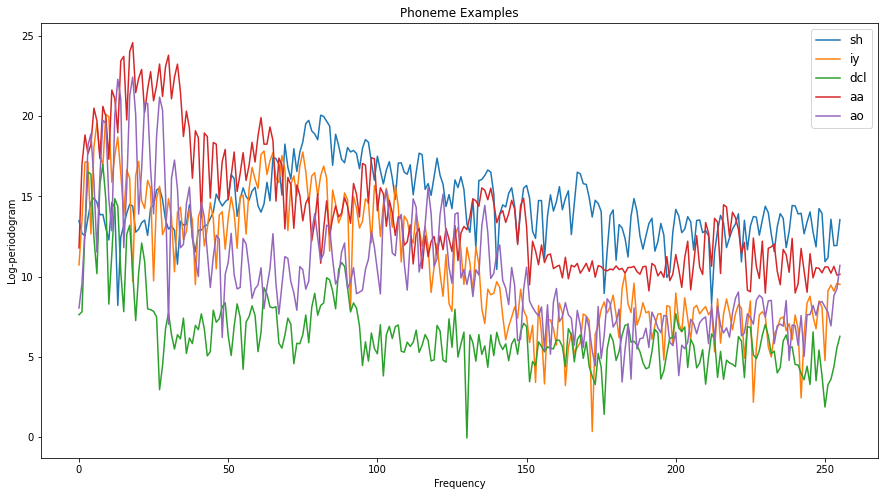

In [3]:
# Plot some sample periodograms
fig, ax = plt.subplots(figsize=(15, 8))

# Sample a log-periodograms for each phoneme
N = len(df)
phonemes = df.g.unique()

for phoneme in phonemes:
    sample = df[df.g == phoneme].sample(n=1)
    ax.plot(sample.iloc[0, :-2], label=phoneme)

# Plot parameters
ax.set_xticks(range(0, 256, 50))
ax.set_xticklabels(range(0, 256, 50))

ax.set_xlabel('Frequency')
ax.set_ylabel('Log-periodogram')

ax.set_title('Phoneme Examples')

ax.legend(fontsize=12);

In [4]:
# Split into training and test
df['set'] = df.speaker.str.split('.', expand=True)[0]
train = df[df.set == 'train']
test = df[df.set == 'test']
df = df.drop(columns=['set'])

# Store useful constants
N = len(df)
N_train = len(train)
N_test = len(test)
p = 256

# Split into inputs and outputs
X_train = train.iloc[:, :p].to_numpy()
y_train = train.loc[:, 'g'].to_numpy()

X_test = test.iloc[:, :p].to_numpy()
y_test = test.loc[:, 'g'].to_numpy()

In [5]:
# Fit raw QDA
qda_raw = QDA()
qda_raw.fit(X_train, y_train);

# Calculate raw training error
y_train_est_raw = qda_raw.predict(X_train)
qda_raw_train_err = 1 - accuracy_score(y_train, y_train_est_raw)
print('Raw QDA training misclassification rate: {:.3f}'.format(qda_raw_train_err))

Raw QDA training misclassification rate: 0.000


Raw QDA training misclassification rate: 0.000

Regularised QDA training misclassification rate: 0.059 


Raw QDA test misclassification rate: 0.158

Regularised QDA test misclassification rate: 0.074

In [6]:
def gen_basis_matrix(knots, p=256):
    basis_fun = gen_nat_cubic_spl_basis_fun(knots=knots)
    basis_matrix = np.array([basis_fun(i) for i in range(1, p+1)])
    
    return basis_matrix

In [7]:
def gen_filter(basis_matrix):
    def data_filter(X):
        if X.ndim == 1:
            X = X[np.newaxis, :]
        
        return X @ basis_matrix
    
    return data_filter

In [8]:
# Different positions to try for knots
num_knots = [6, 12, 24, 40, 60]
knot_positions = [np.linspace(1, 256, k, endpoint=False) + 255 / (2*k) for k in num_knots]

# Generate filter function for each set of knots
basis_matrices = [gen_basis_matrix(knots) for knots in knot_positions]
data_filters = [gen_filter(matrix) for matrix in basis_matrices]

# Create pipeline
estimators = [('filter', FunctionTransformer()),
             ('qda', QDA())]
pipe = Pipeline(estimators)

# Create GridSearch for CV
param_grid = {'filter__func' : data_filters}
qda_reg = GridSearchCV(pipe,
                       param_grid,
                       scoring='accuracy',
                       cv=10,
                       return_train_score=True,
                       refit=True)

# Fit to data
qda_reg.fit(X_train, y_train);

In [9]:
knot_positions

[array([ 22.25,  64.75, 107.25, 149.75, 192.25, 234.75]),
 array([ 11.625,  32.875,  54.125,  75.375,  96.625, 117.875, 139.125,
        160.375, 181.625, 202.875, 224.125, 245.375]),
 array([  6.3125,  16.9375,  27.5625,  38.1875,  48.8125,  59.4375,
         70.0625,  80.6875,  91.3125, 101.9375, 112.5625, 123.1875,
        133.8125, 144.4375, 155.0625, 165.6875, 176.3125, 186.9375,
        197.5625, 208.1875, 218.8125, 229.4375, 240.0625, 250.6875]),
 array([  4.1875,  10.5625,  16.9375,  23.3125,  29.6875,  36.0625,
         42.4375,  48.8125,  55.1875,  61.5625,  67.9375,  74.3125,
         80.6875,  87.0625,  93.4375,  99.8125, 106.1875, 112.5625,
        118.9375, 125.3125, 131.6875, 138.0625, 144.4375, 150.8125,
        157.1875, 163.5625, 169.9375, 176.3125, 182.6875, 189.0625,
        195.4375, 201.8125, 208.1875, 214.5625, 220.9375, 227.3125,
        233.6875, 240.0625, 246.4375, 252.8125]),
 array([  3.125,   7.375,  11.625,  15.875,  20.125,  24.375,  28.625,
         32.8

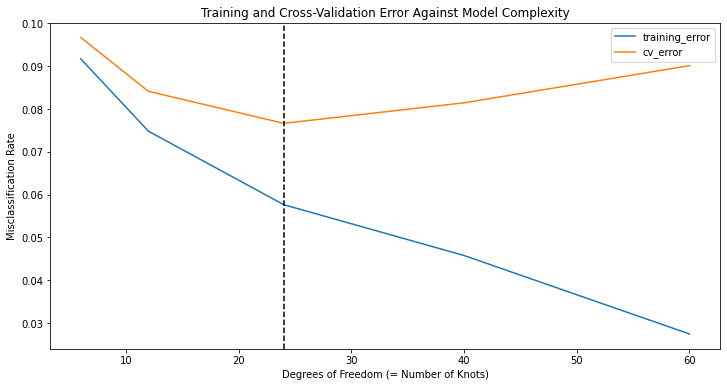

In [10]:
# Initialise figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot errors
ax.plot(num_knots, 1-qda_reg.cv_results_['mean_train_score'], label='training_error')
ax.plot(num_knots, 1-qda_reg.cv_results_['mean_test_score'], label='cv_error')

# Plot value that minimises cv error
ax.axvline(num_knots[qda_reg.best_index_], color='k', ls='--')

# Fig parameters
ax.set_title('Training and Cross-Validation Error Against Model Complexity')
ax.set_xlabel('Degrees of Freedom (= Number of Knots)')
ax.set_ylabel('Misclassification Rate')

ax.legend();

In [11]:
# Calculate raw training error
y_train_est_raw = qda_raw.predict(X_train)
qda_raw_train_err = 1 - accuracy_score(y_train, y_train_est_raw)
print('Raw QDA training misclassification rate: {:.3f}'.format(qda_raw_train_err))

# Calculate regularised training error
y_train_est_reg = qda_reg.predict(X_train)
qda_reg_train_err = 1 - accuracy_score(y_train, y_train_est_reg)
print('Regularised QDA training misclassification rate: {:.3f} \n'.format(qda_reg_train_err))

# Calculate raw test error
y_test_est_raw = qda_raw.predict(X_test)
qda_raw_test_err = 1 - accuracy_score(y_test, y_test_est_raw)
print('Raw QDA test misclassification rate: {:.3f}'.format(qda_raw_test_err))

# Calculate regularised test error
y_test_est_reg = qda_reg.predict(X_test)
qda_reg_test_err = 1 - accuracy_score(y_test, y_test_est_reg)
print('Regularised QDA test misclassification rate: {:.3f}'.format(qda_reg_test_err))

Raw QDA training misclassification rate: 0.000
Regularised QDA training misclassification rate: 0.059 

Raw QDA test misclassification rate: 0.158
Regularised QDA test misclassification rate: 0.074


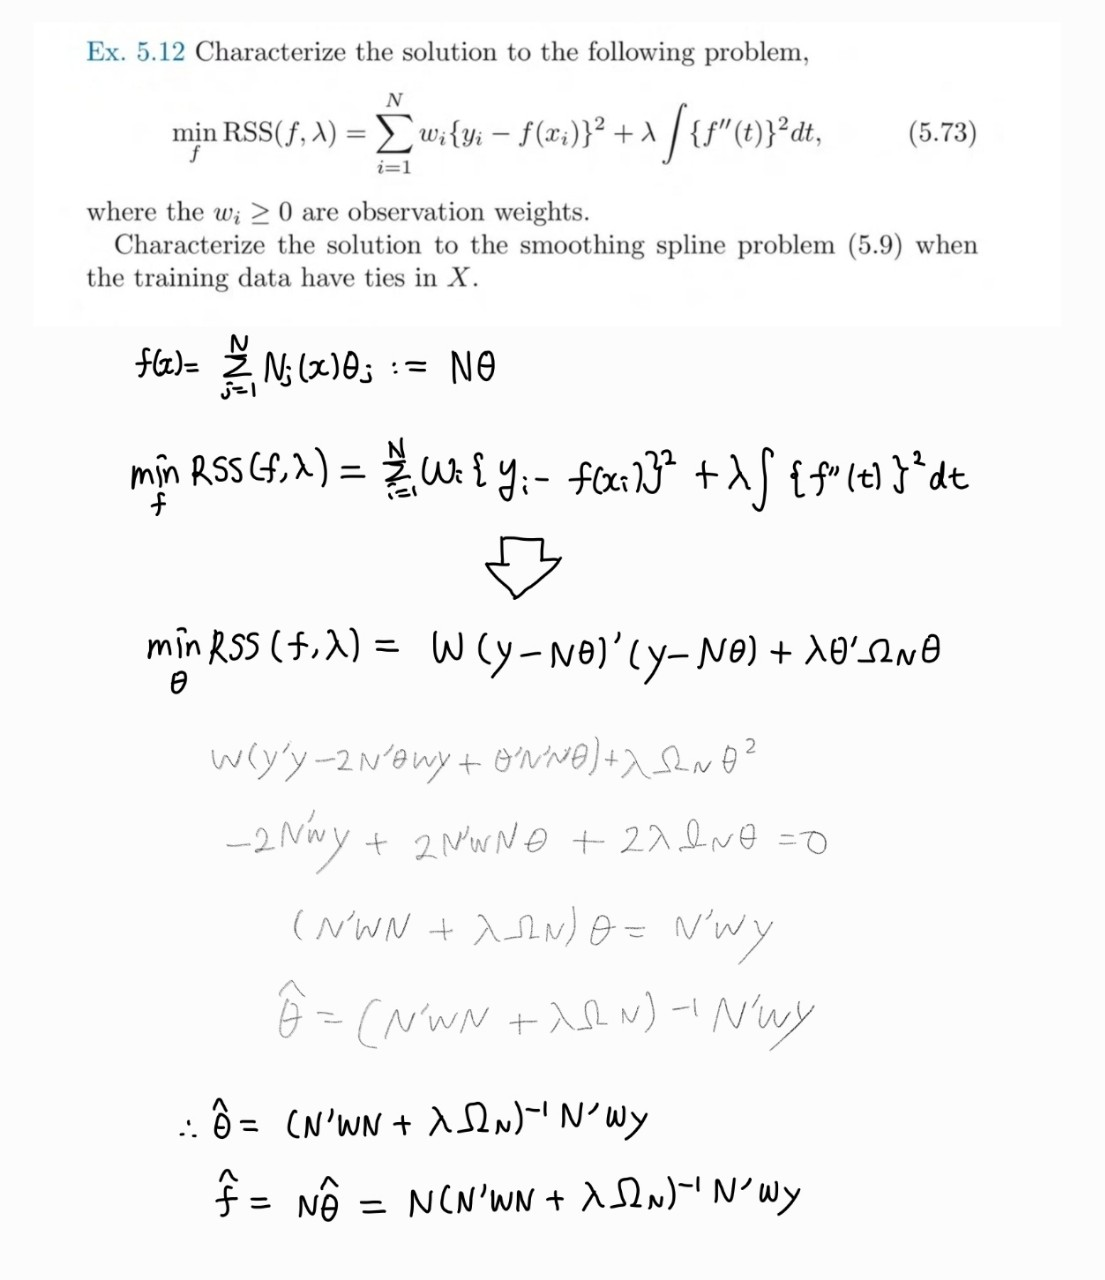

In [12]:
from IPython.display import Image
Image('a.jpg')